# Continuous Control

---


### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import random
import torch
import time
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent, ReplayBuffer

from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher20.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Create an agent instance and Start training

In [5]:
random_seed = random.randint(0,10)
train_mode = True

agent = Agent(state_size=state_size, action_size=action_size, random_seed=random_seed, prioritize=False)

In [6]:
def ddpg(n_episodes=2000, max_t=1000, print_every=10, learn_every=20, num_learn=10, goal_score=30):
    total_scores_deque = deque(maxlen=100)
    total_scores = []
    
    for i_episode in range(1, n_episodes+1):
        # Reset Env and Agent
        env_info = env.reset(train_mode=train_mode)[brain_name]       # reset the environment    
        states = env_info.vector_observations                   # get the current state (for each agent)
        scores = np.zeros(num_agents)                            # initialize the score (for each agent)
        agent.reset()
        
        start_time = time.time()
        
        for t in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]            # send all actions to the environment
            next_states = env_info.vector_observations          # get next state (for each agent)
            rewards = env_info.rewards                          # get reward (for each agent)
            
            dones = env_info.local_done                         # see if episode finished
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done) # send actions to the agent
            
            scores += env_info.rewards                           # update the score (for each agent)
            states = next_states                                # roll over states to next time step
            
            if t%learn_every == 0:
                for _ in range(num_learn):
                    agent.sampleandlearn()
            
            if np.any(dones):                                   # exit loop if episode finished
                break
    
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        total_scores_deque.append(mean_score)
        total_scores.append(mean_score)
        total_average_score = np.mean(total_scores_deque)
        duration = time.time() - start_time
        
        print('\rEpisode {}\tTotal Average Score: {:.2f}\tMean: {:.2f}\tMin: {:.2f}\tMax: {:.2f}\tDuration: {:.2f}'
              .format(i_episode, total_average_score, mean_score, min_score, max_score, duration))

        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tTotal Average Score: {:.2f}'.format(i_episode, total_average_score))  
            
        if total_average_score >= goal_score and i_episode >= 100:
            print('Problem Solved after {} epsisodes!! Total Average score: {:.2f}'.format(i_episode, total_average_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    
    return total_scores

scores = ddpg()


/Users/mac/deep-reinforcement-learning/p2_continuous-control/ddpg_agent.py:104: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 1	Total Average Score: 0.17	Mean: 0.17	Min: 0.00	Max: 0.45	Duration: 129.22
Episode 2	Total Average Score: 0.21	Mean: 0.25	Min: 0.00	Max: 0.99	Duration: 136.48
Episode 3	Total Average Score: 0.36	Mean: 0.65	Min: 0.17	Max: 2.13	Duration: 153.56
Episode 4	Total Average Score: 0.48	Mean: 0.85	Min: 0.00	Max: 2.31	Duration: 140.34
Episode 5	Total Average Score: 0.55	Mean: 0.84	Min: 0.07	Max: 1.95	Duration: 121.83
Episode 6	Total Average Score: 0.61	Mean: 0.90	Min: 0.26	Max: 2.03	Duration: 130.46
Episode 7	Total Average Score: 0.67	Mean: 1.04	Min: 0.00	Max: 2.64	Duration: 152.40
Episode 8	Total Average Score: 0.74	Mean: 1.20	Min: 0.44	Max: 3.42	Duration: 121.77
Episode 9	Total Average Score: 0.85	Mean: 1.77	Min: 0.66	Max: 2.81	Duration: 117.25
Episode 10	Total Average Score: 1.01	Mean: 2.44	Min: 0.00	Max: 5.62	Duration: 119.60
Episode 10	Total Average Score: 1.01
Episode 11	Total Average Score: 1.12	Mean: 2.18	Min: 0.55	Max: 3.62	Duration: 117.20
Episode 12	Total Average Score: 1.26	

Episode 91	Total Average Score: 30.46	Mean: 37.89	Min: 35.80	Max: 39.42	Duration: 222.78
Episode 92	Total Average Score: 30.54	Mean: 37.38	Min: 35.46	Max: 39.12	Duration: 230.88
Episode 93	Total Average Score: 30.62	Mean: 38.01	Min: 35.60	Max: 39.62	Duration: 222.69
Episode 94	Total Average Score: 30.68	Mean: 36.92	Min: 33.76	Max: 38.61	Duration: 220.62
Episode 95	Total Average Score: 30.74	Mean: 36.27	Min: 34.79	Max: 38.33	Duration: 216.57
Episode 96	Total Average Score: 30.80	Mean: 36.43	Min: 26.35	Max: 38.49	Duration: 271.36
Episode 97	Total Average Score: 30.88	Mean: 37.89	Min: 36.25	Max: 39.19	Duration: 294.64
Episode 98	Total Average Score: 30.95	Mean: 37.72	Min: 35.94	Max: 38.63	Duration: 404.94
Episode 99	Total Average Score: 31.01	Mean: 37.62	Min: 35.80	Max: 39.27	Duration: 323.25
Episode 100	Total Average Score: 31.09	Mean: 38.40	Min: 36.73	Max: 39.44	Duration: 314.37
Episode 100	Total Average Score: 31.09
Problem Solved after 100 epsisodes!! Total Average score: 31.09


### 4. Plotting score

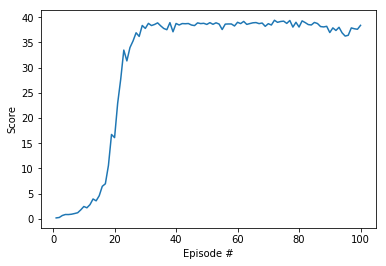

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

### 5. Closing environment

In [ ]:
env.close()